# Bayesian Smoothing

This example is based no Chapter 10 of *[Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions](https://greenteapress.com/wp/probably-overthinking-it)*, University of Chicago Press, 2023.

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [3]:
# download utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate

# Set the random seed so we get the same results every time
np.random.seed(17)

<IPython.core.display.Javascript object>

In [5]:
# This dataset is prepared in GssExtract/notebooks/02_make_extract-2022_3a.ipynb

DATA_PATH = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/"
filename = "gss_extract_2022_3a.hdf"
download(DATA_PATH + filename)

<IPython.core.display.Javascript object>

In [6]:
gss = pd.read_hdf(filename, "gss")
gss.shape

(72390, 54)

<IPython.core.display.Javascript object>

In [7]:
gss["cohort"] = gss["cohort"].replace(9999, np.nan)
gss["cohort"].isna().sum()

755

<IPython.core.display.Javascript object>

In [8]:
def round_to_decade(x):
    return (x // 10) * 10


gss["cohort10"] = gss["cohort"].apply(round_to_decade)
gss["cohort10"].value_counts(dropna=False).sort_index()

cohort10
1880.0       45
1890.0      501
1900.0     1722
1910.0     3616
1920.0     5862
1930.0     7115
1940.0    10925
1950.0    14273
1960.0    11699
1970.0     7681
1980.0     5088
1990.0     2563
2000.0      545
NaN         755
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [9]:
from smooth import (
    plot_titles,
    plot_by_year,
    plot_by_cohort,
    make_table,
    plot_group,
    plot_table,
)

<IPython.core.display.Javascript object>

In [10]:
def decorate_by_year():
    plot_titles(title, subtitle)
    decorate(
        xlabel="Year of Survey",
        xlim=xlim,
        ylim=ylim,
    )

<IPython.core.display.Javascript object>

In [11]:
def decorate_by_cohort():
    plot_titles(title, subtitle)
    decorate(
        xlabel="Year of Birth",
        xlim=xlim,
        ylim=ylim,
    )

<IPython.core.display.Javascript object>

In [12]:
def decorate_group():
    decorate(
        xlabel="Year of survey",
        xlim=xlim,
        ylim=ylim,
        loc="lower left",
    )

<IPython.core.display.Javascript object>

In [13]:
def decorate_table():
    decorate(
        xlabel="Year of survey",
        xlim=xlim,
        ylim=ylim,
        legend=False,
    )

<IPython.core.display.Javascript object>

## helpful

In [14]:
# https://gssdataexplorer.norc.org/variables/439/vshow

# 1 = helpful
# 2 = look out for themselves
# 3 = depends

<IPython.core.display.Javascript object>

In [15]:
yvar = "helpful"
yval = 1

series = gss[yvar]
series.value_counts()

helpful
1.0    20471
2.0    18972
3.0     2971
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [16]:
question = """Would you say that most of the time people try to be helpful, 
or that they are mostly just looking out for themselves?
"""

title = "Would people be helpful or look out for themselves?"
subtitle = "Percent saying helpful"
xlim = [1970.5, 2024.5]
ylim = [15, 75]

<IPython.core.display.Javascript object>

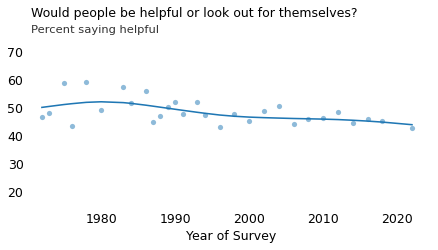

<IPython.core.display.Javascript object>

In [17]:
plot_by_year(gss, yvar, yval)
decorate_by_year()
plt.savefig(f"optimism_{yvar}_by_year", dpi=300)

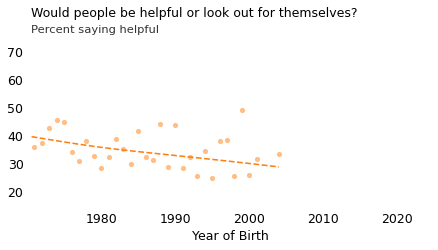

<IPython.core.display.Javascript object>

In [18]:
plot_by_cohort(gss, yvar, yval)
decorate_by_cohort()
plt.savefig(f"optimism_{yvar}_by_cohort", dpi=300)

In [19]:
subset = gss.dropna(subset=["cohort", yvar]).copy()
subset["cohort10"] = subset["cohort10"].astype(int)

table = make_table(subset, "year", yvar, "cohort10", yval)

<IPython.core.display.Javascript object>

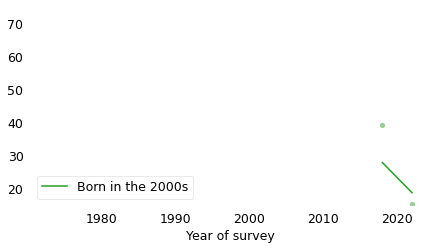

<IPython.core.display.Javascript object>

In [20]:
plot_group(table, 2000)
decorate_group()
plt.savefig(f"optimism_{yvar}_one_cohort", dpi=300)

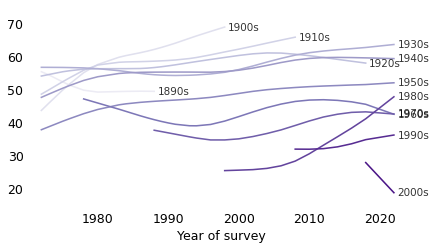

<IPython.core.display.Javascript object>

In [21]:
nudge = {"1960s": 0, "1970s": 0}
plot_table(table, nudge)
decorate_table()
plt.savefig(f"optimism_{yvar}_by_cohort_over_year", dpi=300)

In [54]:
def joint_contour(xs, ys, p, cmap="Blues"):
    X, Y = np.meshgrid(xs, ys, indexing="ij")
    plt.contour(X, Y, p, cmap=cmap)

<IPython.core.display.Javascript object>

<Axes: xlabel='x'>

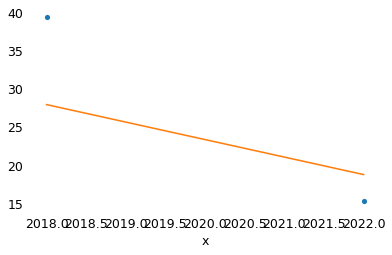

<IPython.core.display.Javascript object>

In [55]:
from smooth import bayesian_smooth

xvar = "year"
yvar = "helpful"
yval = 1

subset = gss.query("cohort10==2000").dropna(subset=[xvar, yvar])

actual, pred = bayesian_smooth(subset, xvar, yvar, yval)
actual.plot(style="o")
pred.plot()

In [56]:
m = subset["year"].median()
m

2022.0

<IPython.core.display.Javascript object>

In [57]:
subset["y"] = subset[yvar] == yval
subset["x"] = subset["year"] - m

<IPython.core.display.Javascript object>

In [58]:
ns = subset.groupby("x")["y"].count()
ns

x
-4.0    28
 0.0    98
Name: y, dtype: int64

<IPython.core.display.Javascript object>

In [59]:
ks = subset.groupby("x")["y"].sum()
xs = ks.index
ks

x
-4.0    11
 0.0    15
Name: y, dtype: int64

<IPython.core.display.Javascript object>

In [60]:
actual = ks / ns
actual.index = xs + m
actual

x
2018.0    0.392857
2022.0    0.153061
Name: y, dtype: float64

<IPython.core.display.Javascript object>

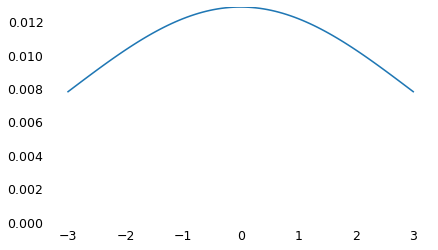

<IPython.core.display.Javascript object>

In [61]:
from scipy.stats import norm

alphas = np.linspace(-3, 3, 91)
alpha_prior = norm.pdf(alphas, 0, 3)
alpha_prior /= alpha_prior.sum()

plt.plot(alphas, alpha_prior)
decorate(ylim=[0, alpha_prior.max()])

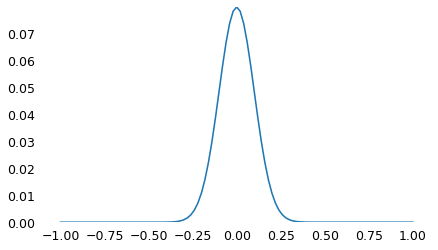

<IPython.core.display.Javascript object>

In [62]:
betas = np.linspace(-1, 1, 101)
beta_prior = norm.pdf(betas, 0, 0.1)
beta_prior /= beta_prior.sum()

plt.plot(betas, beta_prior)
decorate(ylim=[0, beta_prior.max()])

In [63]:
AP, BP = np.meshgrid(alpha_prior, beta_prior, indexing="ij")
joint_prior = AP * BP

<IPython.core.display.Javascript object>

In [64]:
def joint_contour(xs, ys, p, cmap="Blues"):
    X, Y = np.meshgrid(xs, ys, indexing="ij")
    plt.contour(X, Y, p, cmap=cmap)

<IPython.core.display.Javascript object>

In [65]:
from scipy.special import expit
from scipy.stats import binom

joint_posterior = joint_prior.copy()
A, B = np.meshgrid(alphas, betas, indexing="ij")

for x in xs:
    k = ks[x]
    n = ns[x]
    P = expit(A + B * x)
    print(x, k, n, k / n)
    likelihood = binom.pmf(k, n, P)
    joint_posterior *= likelihood

joint_posterior /= joint_posterior.sum()

-4.0 11 28 0.39285714285714285
0.0 15 98 0.15306122448979592


<IPython.core.display.Javascript object>

-1.484695588268882

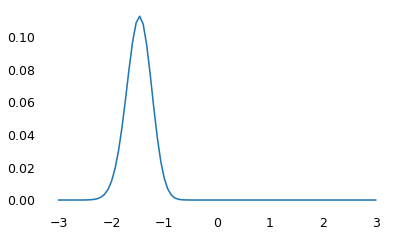

<IPython.core.display.Javascript object>

In [66]:
marginal_alpha = joint_posterior.sum(axis=1)
plt.plot(alphas, marginal_alpha)
np.sum(alphas * marginal_alpha)

-0.12789020091816924

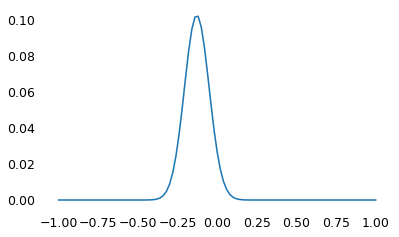

<IPython.core.display.Javascript object>

In [67]:
marginal_beta = joint_posterior.sum(axis=0)
plt.plot(betas, marginal_beta)
np.sum(betas * marginal_beta)

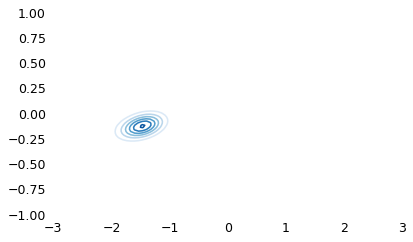

<IPython.core.display.Javascript object>

In [68]:
joint_contour(alphas, betas, joint_posterior)

In [69]:
ps = [np.sum(joint_posterior * expit(A + B * x)) for x in xs]
pred = pd.Series(ps, actual.index)
pred

x
2018.0    0.278669
2022.0    0.187370
dtype: float64

<IPython.core.display.Javascript object>

<Axes: xlabel='x'>

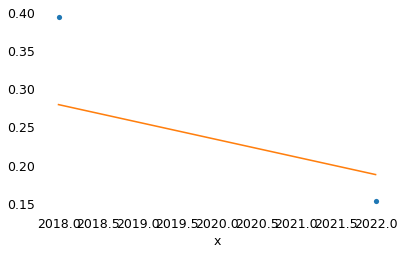

<IPython.core.display.Javascript object>

In [70]:
actual.plot(style="o")
pred.plot()

Copyright 2024 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).